## Exploratory Data Analysis

In [1]:
## load packages
import os 
import pathlib
import pickle as pkl
import gdown

import sklearn
import seaborn as sns
import pyarrow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import re

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from feature_processing import encode_multi_features, encode_categorical
pd.set_option('display.max_columns', None)

### file: BILLS
- Remove rows where 'status'=NA
- Remove dupliacted rows 
- Plot distribution of 'status'

In [4]:
bills = pd.read_parquet("../data/raw/chorus/bills.parquet") # load data frame
print(f"Number of rows in BILLS: {len(bills)}\nNumber of rows with status=NA: {len(bills[bills["status"].isna()])}")
bills = bills[bills["status"].notna()] #remove rows where status=NA (this is the outcome var)
print(f"Number of rows in BILLS when status=NA is removed: {len(bills)}")

Number of rows in BILLS: 588786
Number of rows with status=NA: 52079
Number of rows in BILLS when status=NA is removed: 536707


In [ ]:
# duplicated state_unified_bill_id:
bills_dupl = bills[bills.duplicated(subset = "state_unified_bill_id", keep=False)]
print(f"number of state_unified_bill_id values that are present twice: {len(bills_dupl)/2}")
print(bills_dupl.value_counts("state"))
print(bills_dupl.value_counts(["state", "bill_suffix"])) 

# define index values of rows to remove
ind_suffix_A = bills_dupl[bills_dupl["bill_suffix"] == "A"].index.tolist() #(468)
ind_IL = bills_dupl.loc[(bills_dupl["state"] == "IL") & (bills_dupl["bill_chamber"] == "HJR")].index.tolist() #(2)
ind_TX_NJ = bills_dupl[(bills_dupl["state"].isin(["TX", "NJ"])) & (bills_dupl["date_overlap_jaccard"].isna())].index.tolist() #(896)
ind_WI = bills_dupl[(bills_dupl["state"] == "WI") & (bills_dupl["bill_suffix"].notna())].index.tolist() # (3)
dupl = ind_WI + ind_IL + ind_TX_NJ + ind_suffix_A

# remove rows from BILLS
bills = bills.drop(dupl)
print(f"number of bills after duplictates have been removed: {len(bills)}")
del ind_IL, ind_suffix_A, ind_WI, ind_TX_NJ, dupl, bills_dupl

number of state_unified_bill_id values that are present twice: 1369.0
state
NJ    1774
NE     936
TX      18
WI       6
IL       4
Name: count, dtype: int64
state  bill_suffix
NE     A              468
WI     DE               2
       JN               1
Name: count, dtype: int64
number of bills after duplictates have been removed: 535338


In [6]:
#set index to bill_id value (after dups have been removed these are unique)
bills.set_index("state_unified_bill_id", inplace=True) 
#create map of passed and failed bills to each bill id
bills_outcome = bills["status"].isin([4,5]).to_dict()
# create new col with binary pass/fail status
bills["pass"] = bills.index.map(bills_outcome)

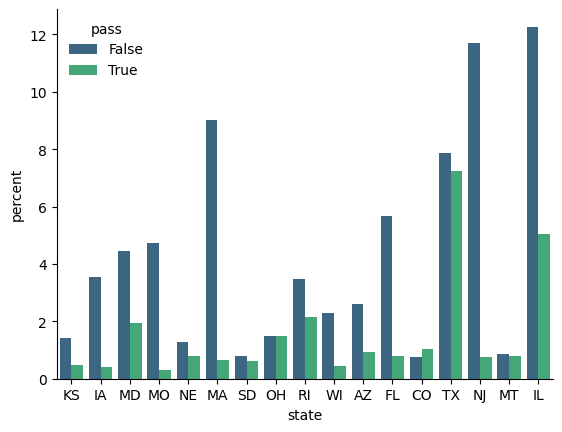

In [7]:
#plot outcomes(passed/failed) by state
p = sns.countplot(bills, x = "state", hue = "pass",stat = "percent", palette= "viridis")
sns.move_legend(p, "upper left", frameon = False)
sns.despine()

In [8]:
#change column to datetime format in other version : rm rows where last_action_date =0000-00-00
bills_dates = bills[bills["last_action_date"] != "0000-00-00"]
bills_dates["last_action_date"] = pd.to_datetime(bills_dates["last_action_date"].iloc[0:], format="%Y-%m-%d")
bills_dates["month_year"] = bills_dates["last_action_date"].dt.to_period("M")
bills_dates = pd.DataFrame(bills_dates.value_counts(["month_year", "pass"])).reset_index().sort_values("month_year").reset_index(drop=True)
bills_dates["month_year"] = bills_dates["month_year"].astype(str)

/tmp/ipykernel_539/709810930.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bills_dates["last_action_date"] = pd.to_datetime(bills_dates["last_action_date"].iloc[0:], format="%Y-%m-%d")
/tmp/ipykernel_539/709810930.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bills_dates["month_year"] = bills_dates["last_action_date"].dt.to_period("M")


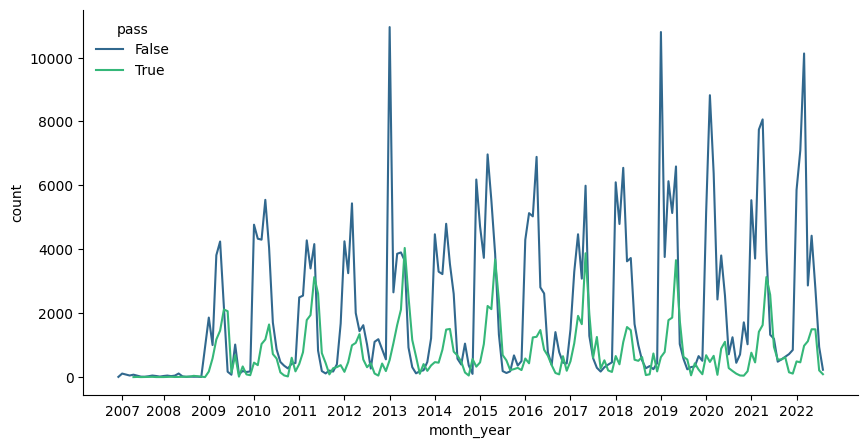

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
p = sns.lineplot(bills_dates, x = "month_year", y = "count", hue = "pass", 
                 palette="viridis")
sns.move_legend(p, "upper left", frameon=False)
sns.despine()
plt.xticks([1, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, 180],
           ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015','2016','2017','2018','2019','2020','2021','2022'])
plt.show()

In [ ]:
#write cleaned 'bills' to parquet
bills.to_parquet("../data/preprocessed/bills.parquet", engine = "pyarrow")

### file: POSITIONS & CLIENTS

- remove positions by private citizens (rows with no state client id)
- remove recorded positions on bills not in the bills df

In [37]:
bills_clean = pd.read_parquet("../data/preprocessed/bills.parquet")
positions = pd.read_parquet("../data/raw/chorus/positions.parquet")
blocks = pd.read_parquet("../data/raw/chorus/block_assignments.parquet")
clients = pd.read_parquet("../data/raw/chorus/clients.parquet")

for representing lobbying i need: 
- three columns (with lists): blocks_oppose, blocks_neutral, blocks_support
and 
- three columns (with lists): n_oppose, n_neutral, n_support

In [38]:
bills_clean

,legiscan_bill_id,legiscan_bill,legiscan_url,status_date,status,last_action_date,last_action,title,description,year_start,year_end,prefile,sine_die,prior,session_title,state,bill_chamber,bill_number,bill_suffix,sponsor_list,description_ncsl,ncsl_summary,date_overlap_jaccard,title_overlap_jaccard,ncsl_topics,ncsl_databases,ncsl_metatopics,pass
state_unified_bill_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
KS_HB_0000002001_2013,450474.0,HB2001,https://legiscan.com/KS/bill/HB2001/2013,2014-05-30,6.0,2014-05-30,House Died in Committee,"Substitute HB 2001 by Committee on Veterans, M...","Substitute HB 2001 by Committee on Veterans, M...",2013.0,2014.0,0.0,1.0,1.0,2013-2014 Regular Session,KS,HB,2001,None,"['Veterans, Military and Homeland Security']",National Guard Educational Assistance Act,Relates to the national guard educational assi...,0.067164,0.263158,ncsl_database__military_and_veterans_state_leg...,ncsl_database__military_and_veterans_state_leg...,ncsl_metatopic__military_and_veterans_affairs,False
KS_HB_0000002002_2013,450475.0,HB2002,https://legiscan.com/KS/bill/HB2002/2013,2014-04-30,4.0,2014-04-30,"House Approved by Governor on Thursday, 10 Apr...",Substitute for HB 2002 by Committee on Federal...,Substitute for HB 2002 by Committee on Federal...,2013.0,2014.0,0.0,1.0,1.0,2013-2014 Regular Session,KS,HB,2002,None,['Federal and State Affairs'],None,None,NaN,NaN,None,None,None,True
KS_HB_0000002011_2013,451743.0,HB2011,https://legiscan.com/KS/bill/HB2011/2013,2013-05-08,4.0,2013-05-08,"House Approved by Governor on Tuesday, 16 Apri...",Senate Substitute for HB 2011 by Committee on ...,Senate Substitute for HB 2011 by Committee on ...,2013.0,2014.0,0.0,1.0,1.0,2013-2014 Regular Session,KS,HB,2011,None,['Transportation'],None,None,NaN,NaN,None,None,None,True
KS_HB_0000002101_2013,472087.0,HB2101,https://legiscan.com/KS/bill/HB2101/2013,2014-04-30,4.0,2014-04-30,"House Approved by Governor on Wednesday, 16 Ap...",Senate Substitute for HB 2101 by Committee on ...,Senate Substitute for HB 2101 by Committee on ...,2013.0,2014.0,0.0,1.0,1.0,2013-2014 Regular Session,KS,HB,2101,None,['Utilities'],None,None,NaN,NaN,None,None,None,True
KS_SB_0000000118_2013,485433.0,SB118,https://legiscan.com/KS/bill/SB118/2013,2013-04-05,4.0,2013-04-05,"Senate Approved by Governor on Friday, 05 Apri...",Relating to law enforcement reporting and inve...,Relating to law enforcement reporting and inve...,2013.0,2014.0,0.0,1.0,1.0,2013-2014 Regular Session,KS,SB,118,None,['Greg Smith'],None,None,NaN,NaN,None,None,None,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MD_HB_0000001806_2012-X1,435487.0,HB1806,https://legiscan.com/MD/bill/HB1806/2012/X1,2012-05-14,1.0,2012-05-14,First Reading House Rules and Executive Nomina...,Courts - Dog Bite Lawsuits - Evidence and Stan...,Establishing that in a cause of action involvi...,2012.0,2012.0,0.0,1.0,1.0,2012 1st Special Session,MD,HB,1806,None,['Benjamin Kramer'],None,None,NaN,NaN,None,None,None,False
MD_HB_0000001807_2012-X1,435460.0,HB1807,https://legiscan.com/MD/bill/HB1807/2012/X1,2012-05-14,1.0,2012-05-14,First Reading House Rules and Executive Nomina...,The Maryland Dog Nondiscrimination Act,Establishing that in a cause of action involvi...,2012.0,2012.0,0.0,1.0,1.0,2012 1st Special Session,MD,HB,1807,None,['Herbert McMillan'],None,None,NaN,NaN,None,None,None,False
MD_HB_0000001808_2012-X1,435433.0,HB1808,https://legiscan.com/MD/bill/HB1808/2012/X1,2012-05-14,1.0,2012-05-14,First Reading House Rules and Executive Nomina...,Courts - Civil Liability for Injuries Inflicte...,Establishing that no person may be held civill...,2012.0,2012.0,0.0,1.0,1.0,2012 1st Special Session,MD,HB,1808,None,"['Frank Turner', 'Eric Luedtke', 'Aruna Miller...",None,None,NaN,NaN,None,None,None,False


In [3]:
cl_merge = clients.merge(blocks[["state", "entity_id", "block_1"]].rename(columns={"entity_id": "state_client_id"}), on=["state_client_id", "state"])
cl_merge["block_state"] = cl_merge["state"]+"_"+cl_merge["block_1"].astype(str)
cl_merge.drop_duplicates(subset=["state_client_id", "block_1"], inplace = True)
cl_merge.sort_values(by = ["state", "block_1"], inplace=True)

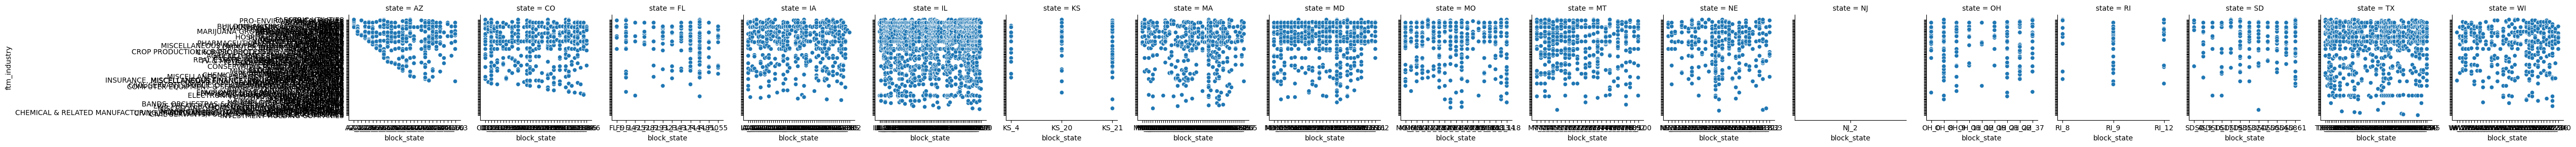

In [ ]:
#fig, ax = plt.subplots(figsize=(10, 10))
g = sns.FacetGrid(cl_merge, col="ftm_industry", sharex = False)
g.map_dataframe(sns.scatterplot, x="block_state", y="ftm_industry", hue = "state")

In [31]:
features, names = encode_categorical(blocks, ["block_1"])

In [33]:
blocks

,entity_id,block_0,block_1,block_2,block_3,block_4,block_5,block_6,state,record_type
0,MA_1,3283,150,0,12,3.0,3.0,2.0,MA,lobbying
1,MA_10,4139,20,27,26,0.0,3.0,2.0,MA,lobbying
2,MA_100,3291,209,42,6,0.0,3.0,2.0,MA,lobbying
3,MA_1000,1311,128,62,26,0.0,3.0,2.0,MA,lobbying
4,MA_1001,97,169,68,6,0.0,3.0,2.0,MA,lobbying
...,...,...,...,...,...,...,...,...,...,...
82631,RI_S_0000002245_2022,261,5,2,0,0.0,NaN,NaN,RI,lobbying
82632,RI_H_0000007427_2018,261,5,2,0,0.0,NaN,NaN,RI,lobbying
82633,RI_S_0000002475_2018,261,5,2,0,0.0,NaN,NaN,RI,lobbying
82634,RI_H_0000005127_2019,261,5,2,0,0.0,NaN,NaN,RI,lobbying


In [29]:
#print(blocks.groupby("state").nunique())
blocks_1 = blocks["block_1"].unique()
blocks_1.sort()
print(blocks_1)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 223 224 226 227 228 229 230 231 232 233 234 235
 236 238 239 240 242 243 244 245 246 247 248 249 25

In [ ]:
##example rep positions

test = positions[positions["state_unified_bill_id"] =="AZ_HB_0000002001_2006"][["position_numeric", "state_client_id"]]

print(blocks[blocks["entity_id"].isin(test["state_client_id"])])
test




      entity_id  block_0  block_1  block_2  block_3  block_4  block_5  \
50466    AZ_108     3454       63       19        2      1.0      3.0   
50929     AZ_28     1804      128        4       16      1.0      3.0   

       block_6 state record_type  
50466      NaN    AZ   testimony  
50929      NaN    AZ   testimony  


,position_numeric,state_client_id
13282944,-1.0,AZ_28
13282945,1.0,AZ_108
13283128,-1.0,AZ_28
13283129,1.0,AZ_108
13295140,-1.0,AZ_28
13295141,1.0,AZ_108
13295839,-1.0,AZ_28
13295840,1.0,AZ_108
13297214,-1.0,AZ_28
13297215,1.0,AZ_108


In [ ]:
#clean positions to only include orgs (w. state client id)
print(f"number of positions in total: {len(positions)}\npercentage of these made by private individuals: {round(len(positions[positions["state_client_id"].notnull()])/len(positions)*100, 2)}%")
positions = positions[positions["state_client_id"].notnull()] #remove positions not made by orgs
print(f"number of positions after removing ones made by private individuals: {len(positions)}")
#clean positions to only include ones made on bills in dataset
bills_id = bills_clean.index.tolist() #all bills
print(f"\nnumber of bills with related positions not in the bills dataset: {len()}")


number of positions in total: 6015401
percentage of these made by private individuals: 100.0%
number of positions after removing ones made by private individuals: 6015401


In [170]:
blocks.value_counts(["state", "block_0"], sort = False).to_csv("data.txt", sep = "\t")

In [177]:
blocks[["block_0", "block_1", "block_2", "block_3", "state"]].drop_duplicates().sort_values(by = ["state", "block_3", "block_2", "block_1", "block_0"])

,block_0,block_1,block_2,block_3,state
51252,64,129,5,0,AZ
51237,2592,129,5,0,AZ
51634,2668,129,5,0,AZ
51233,1594,145,5,0,AZ
51270,2810,145,5,0,AZ
...,...,...,...,...,...
43044,3528,166,74,26,WI
42984,1372,236,74,26,WI
43038,3010,236,74,26,WI
42970,4438,236,74,26,WI


In [145]:
blocks.sort_values(by="block_0", ascending=False).to_csv("data2.txt", sep = "\t", index = False)

In [129]:
bills_clean[bills_clean.index == "RI_H_0000007938_2019"]

,legiscan_bill_id,legiscan_bill,legiscan_url,status_date,status,last_action_date,last_action,title,description,year_start,year_end,prefile,sine_die,prior,session_title,state,bill_chamber,bill_number,bill_suffix,sponsor_list,description_ncsl,ncsl_summary,date_overlap_jaccard,title_overlap_jaccard,ncsl_topics,ncsl_databases,ncsl_metatopics,pass
state_unified_bill_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [128]:
positions[~positions["state_unified_bill_id"].isin(bills_id)]["state_unified_bill_id"].unique()

array(['NJ_S_0000001235_2014', 'NJ_S_0000000017_2014',
       'NJ_S_0000003631_2014', ..., 'RI_H_0000007200_2019',
       'RI_S_0000002670_2019', 'RI_H_0000007938_2019'],
      shape=(49193,), dtype=object)

(array([  17966.,   18415.,   41134.,   37813.,   68205.,  178858.,
         299155.,  241223.,  533547.,  662312.,  883824.,  586837.,
        1191668.,  908867.,  345577.]),
 array([1997.        , 1998.73333333, 2000.46666667, 2002.2       ,
        2003.93333333, 2005.66666667, 2007.4       , 2009.13333333,
        2010.86666667, 2012.6       , 2014.33333333, 2016.06666667,
        2017.8       , 2019.53333333, 2021.26666667, 2023.        ]),
 <BarContainer object of 15 artists>)

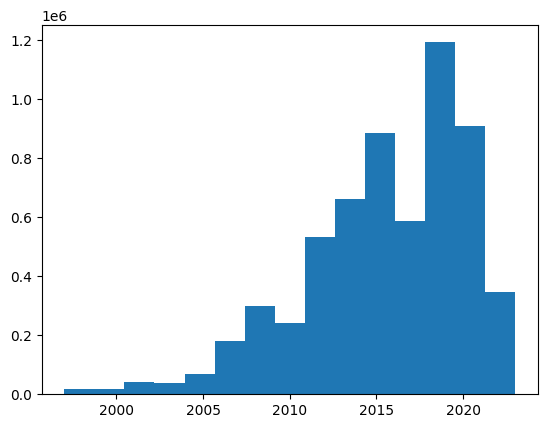

In [106]:
plt.hist(positions["year"], bins = 15)

(array([ 1001.,     0., 41810., 20378., 52582., 19082., 54788., 20776.,
        56085., 21974., 58303., 25346., 57369., 25361., 80483.]),
 array([2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015.,
        2016., 2017., 2018., 2019., 2020., 2021., 2022.]),
 <BarContainer object of 15 artists>)

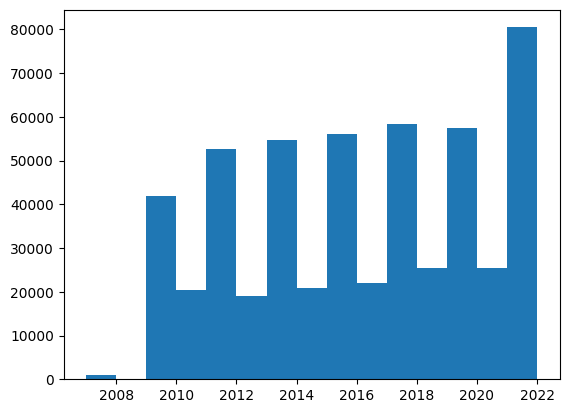

In [105]:
plt.hist(bills_clean["year_start"], bins = 15)

In [98]:
#number of clients per state (in clients df)
print(f"number of unique clients: {len(clients["state_client_id"].unique())}\nnumber of unique clients by state:")
print(clients[["state", "state_client_id"]].drop_duplicates(ignore_index=True).value_counts("state", sort = False))
client_id_unique = clients["state_client_id"].unique()
blocks[blocks["entity_id"].str.contains("RI_9") ]

number of unique clients: 329143
number of unique clients by state:
state
AZ      2439
CO     14660
FL     18755
IA      1821
IL    105856
KS      9519
MA      3169
MD     10110
MO     24360
MT      5913
NE      1521
NJ      4759
OH      9595
RI       419
SD      8377
TX     58994
WI     48876
Name: count, dtype: int64


,entity_id,block_0,block_1,block_2,block_3,block_4,block_5,block_6,state,record_type
82396,RI_91,185,8,9,3,0.0,NaN,NaN,RI,lobbying
82397,RI_92,291,8,9,3,0.0,NaN,NaN,RI,lobbying
82398,RI_97,291,8,9,3,0.0,NaN,NaN,RI,lobbying
82399,RI_98,227,9,9,3,0.0,NaN,NaN,RI,lobbying


number of positions in total: 13619409
percentage of these made by private individuals: 44.17%
number of positions after removing ones made by private individuals: 6015401


In [82]:
#blocks_id_unique.str.split("_", expand=True).value_counts(0, sort = False)
#blocks[blocks["entity_id"].str.contains("[A-Z][A-Z]_[0-9]")]["entity_id"].tolist()

print(blocks[blocks["entity_id"].str.contains(r"^NJ_(\d+)")]["entity_id"].tolist())
print(positions[positions["state_client_id"].str.contains(r"^NJ_(\d+)")]["state_client_id"].sort_values().unique().tolist())

/tmp/ipykernel_805/1267147572.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  print(blocks[blocks["entity_id"].str.contains(r"^NJ_(\d+)")]["entity_id"].tolist())
/tmp/ipykernel_805/1267147572.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  print(positions[positions["state_client_id"].str.contains(r"^NJ_(\d+)")]["state_client_id"].sort_values().unique().tolist())


['NJ_0', 'NJ_10', 'NJ_1002', 'NJ_1004', 'NJ_1006', 'NJ_1012', 'NJ_1019', 'NJ_102', 'NJ_1021', 'NJ_1025', 'NJ_1036', 'NJ_1037', 'NJ_1042', 'NJ_1047', 'NJ_1048', 'NJ_1054', 'NJ_1061', 'NJ_1062', 'NJ_1066', 'NJ_1070', 'NJ_1071', 'NJ_1075', 'NJ_1094', 'NJ_1096', 'NJ_11', 'NJ_1112', 'NJ_1114', 'NJ_1116', 'NJ_112', 'NJ_1120', 'NJ_1127', 'NJ_1131', 'NJ_1134', 'NJ_114', 'NJ_1149', 'NJ_1150', 'NJ_1156', 'NJ_1158', 'NJ_116', 'NJ_1161', 'NJ_1163', 'NJ_1168', 'NJ_1171', 'NJ_1177', 'NJ_1189', 'NJ_119', 'NJ_1190', 'NJ_1192', 'NJ_120', 'NJ_1206', 'NJ_121', 'NJ_122', 'NJ_1220', 'NJ_123', 'NJ_1231', 'NJ_1235', 'NJ_1237', 'NJ_1238', 'NJ_1239', 'NJ_124', 'NJ_1240', 'NJ_1245', 'NJ_1247', 'NJ_1267', 'NJ_1269', 'NJ_1275', 'NJ_1276', 'NJ_1278', 'NJ_128', 'NJ_1296', 'NJ_1297', 'NJ_130', 'NJ_1301', 'NJ_1308', 'NJ_131', 'NJ_1311', 'NJ_1312', 'NJ_1322', 'NJ_133', 'NJ_1333', 'NJ_1335', 'NJ_134', 'NJ_1345', 'NJ_135', 'NJ_136', 'NJ_1360', 'NJ_1361', 'NJ_1368', 'NJ_137', 'NJ_138', 'NJ_139', 'NJ_1397', 'NJ_1398', 'NJ

In [99]:
#number of unique clients in blocks df
print(f"number of unique clients in 'blocks': {len(blocks[blocks["entity_id"].str.contains(r"^([A-Z]+)_(\d+)")]["entity_id"])}")
blocks_id_unique = blocks[blocks["entity_id"].str.contains(r"^([A-Z]+)_(\d+)")]["entity_id"]
#number of unique clients in positions df
print(f"number of unqiue clients in 'positions': {len(positions["state_client_id"].unique())}")
positions_id_unique = pd.Series(positions["state_client_id"].unique())
#number of postion client ids representd and not represented in blocks df 
print(positions_id_unique.isin(blocks_id_unique).value_counts())
#positions with client ids not in blocks
positions_notinblocks = positions[~positions["state_client_id"].isin(blocks_id_unique)]
positions_notinblocks["state"].value_counts(sort = False)
positions_notinblocks
positions

#clients[clients["state_client_id"].isin(positions_id_unique)].drop_duplicates("state_client_id")

/tmp/ipykernel_805/3434064994.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  print(f"number of unique clients in 'blocks': {len(blocks[blocks["entity_id"].str.contains(r"^([A-Z]+)_(\d+)")]["entity_id"])}")
/tmp/ipykernel_805/3434064994.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  blocks_id_unique = blocks[blocks["entity_id"].str.contains(r"^([A-Z]+)_(\d+)")]["entity_id"]


number of unique clients in 'blocks': 19464
number of unqiue clients in 'positions': 274200
False    254985
True      19215
Name: count, dtype: int64


,bill_version,client_name,lobbyist_rep_name,lobbyist_firm_name,position,start_date,end_date,year,record_type,session,description,committee,state,position_numeric,docket_number,docket_prefix,legiscan_bill_id,state_unified_bill_id,state_client_id,ncsl_metatopics,ncsl_topics
0,None,NJBA,None,None,O,NaT,NaT,2014,lobbying,2014-2015,"Agriculture and Food - ""The """"Preserve New Jer...",None,NJ,-1.0,None,None,595945.0,NJ_A_0000001363_2014,NJ_0,None,None
1,None,NJBA,None,None,O,NaT,NaT,2014,lobbying,2014-2015,Agriculture and Food - Imposes water consumpti...,None,NJ,-1.0,None,None,595591.0,NJ_A_0000001364_2014,NJ_0,None,None
2,None,NJBA,None,None,O,NaT,NaT,2014,lobbying,2014-2015,"Agriculture and Food - """"""Water Supply Open Sp...",None,NJ,-1.0,None,None,597169.0,NJ_A_0000001483_2014,NJ_0,ncsl_metatopic__transportation,ncsl_database__state_traffic_safety_legislatio...
3,None,NJBA,None,None,P,NaT,NaT,2014,lobbying,2014-2015,Agriculture and Food - Permits construction of...,None,NJ,1.0,None,None,597358.0,NJ_A_0000001711_2014,NJ_0,None,None
4,None,NPPC,None,None,O,NaT,NaT,2014,lobbying,2014-2015,Agriculture and Food - Establishes animal crue...,None,NJ,-1.0,None,None,596237.0,NJ_A_0000001814_2014,NJ_1,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13619404,None,CLEAN WATER ACTION,JED THORP,None,PROMOTE,2022-07-01 00:00:00+00:00,2022-09-30 00:00:00+00:00,2022,lobbying,2022,None,None,RI,1.0,None,None,None,RI_S_0000002298_2022,RI_140,None,None
13619405,None,ALLIANCE FOR SAFE COMMUNITIES,CAROLYN JULIA MEDEIROS,None,PROMOTE,2022-07-01 00:00:00+00:00,2022-09-30 00:00:00+00:00,2022,lobbying,2022,None,None,RI,1.0,None,None,None,RI_S_0000002011_2022,RI_93,None,None
13619406,None,ALLIANCE FOR SAFE COMMUNITIES,CAROLYN JULIA MEDEIROS,None,PROMOTE,2022-07-01 00:00:00+00:00,2022-09-30 00:00:00+00:00,2022,lobbying,2022,None,None,RI,1.0,None,None,None,RI_S_0000002012_2022,RI_93,None,None
13619407,None,ALLIANCE FOR SAFE COMMUNITIES,CAROLYN JULIA MEDEIROS,None,OPPOSE,2022-07-01 00:00:00+00:00,2022-09-30 00:00:00+00:00,2022,lobbying,2022,None,None,RI,-1.0,None,None,None,RI_S_0000002135_2022,RI_93,None,None


In [280]:
#summarise positions across states
positions_summ = pd.DataFrame(positions.value_counts(["state", "position_numeric"])).reset_index().pivot(index="state", columns="position_numeric", values="count")#.reset_index()
positions_summ["total_positions"] = positions_summ.apply(np.sum, axis = 1, result_type = "expand")
positions_summ = positions_summ.rename_axis(None, axis=1).reset_index()
positions_summ.rename(columns= {-1.0: "oppose", 0.0: "neutral", 1.0: "support"}, inplace=True)
positions_summ.insert(5, "total_bills", positions.groupby("state")["state_unified_bill_id"].nunique().tolist()) 
positions_summ.assign(oppose_perc = lambda x: round(x["oppose"]/x["total_positions"]*100, 2), 
                      neutral_perc = lambda x: round(x["neutral"]/x["total_positions"]*100, 2), 
                      support_perc = lambda x: round(x["support"]/x["total_positions"]*100, 2))

,state,oppose,neutral,support,total_positions,total_bills,oppose_perc,neutral_perc,support_perc
0,AZ,134654,78272,417493,630419,11677,21.36,12.42,66.22
1,CO,227583,923511,506662,1657756,12847,13.73,55.71,30.56
2,FL,13526,4669,35094,53289,8619,25.38,8.76,65.86
3,IA,90545,531455,167782,789782,22086,11.46,67.29,21.24
4,IL,289773,12417,625642,927832,18379,31.23,1.34,67.43
5,KS,8360,2572,20504,31436,3126,26.59,8.18,65.22
6,MA,111160,210783,153709,475652,29926,23.37,44.31,32.32
7,MD,11631,3005,44367,59003,6614,19.71,5.09,75.19
8,MO,16110,2927,45812,64849,9348,24.84,4.51,70.64
9,MT,38409,38315,77613,154337,10828,24.89,24.83,50.29


ENCODING OF POSITIONS

In [321]:
positions[(positions["state_client_id"].isin(client_1["state_client_id"])) & (positions["state_unified_bill_id"]==bill_1)]

,bill_version,client_name,lobbyist_rep_name,lobbyist_firm_name,position,start_date,end_date,year,record_type,session,description,committee,state,position_numeric,docket_number,docket_prefix,legiscan_bill_id,state_unified_bill_id,state_client_id,ncsl_metatopics,ncsl_topics
5194910,SB2419,IDFPR,Meghan Kolassa,Illinois Department of Financial and Professio...,OPP,2018-05-09 00:00:00+00:00,2018-05-09 00:00:00+00:00,2018,testimony,100,None,H Health Care Licenses,IL,-1.0,None,None,1070487.0,IL_SB_0000002419_2017,IL_1924,None,None
5194911,SB2419,IDFPR,Meghan Kolassa,Illinois Department of Financial and Professio...,OPP,2018-02-14 00:00:00+00:00,2018-02-14 00:00:00+00:00,2018,testimony,100,None,S Licensed Activities and Pensions,IL,-1.0,None,None,1070487.0,IL_SB_0000002419_2017,IL_1924,None,None
5194912,SB2419,Illinois State Assembly of Surgical Technologists,Anna Moran,Illinois Assembly of Surgical Technologists,PROP,2018-05-09 00:00:00+00:00,2018-05-09 00:00:00+00:00,2018,testimony,100,None,H Health Care Licenses,IL,1.0,None,None,1070487.0,IL_SB_0000002419_2017,IL_42086,None,None
5194913,SB2419,Illinois State Assembly for Surgical Technologist,Anne M Farris,Illinois State Assembly Surgical Technologist,PROP,2018-05-09 00:00:00+00:00,2018-05-09 00:00:00+00:00,2018,testimony,100,None,H Health Care Licenses,IL,1.0,None,None,1070487.0,IL_SB_0000002419_2017,IL_42087,None,None
5194915,SB2419,IL State Assembly of Surgical Technologists,Ashlee Lore,IL State Assembly of Surgical Technologists,PROP,2018-05-09 00:00:00+00:00,2018-05-09 00:00:00+00:00,2018,testimony,100,None,H Health Care Licenses,IL,1.0,None,None,1070487.0,IL_SB_0000002419_2017,IL_42088,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6976895,SB2419,Illinois Surgical Assistant Association,Luis F Aragon,American Surgical Professionals,PROP,2018-02-14 00:00:00+00:00,2018-02-14 00:00:00+00:00,2018,testimony,100,None,S Licensed Activities and Pensions,IL,1.0,None,None,1070487.0,IL_SB_0000002419_2017,IL_13660,None,None
6976896,SB2419,IL Surgical Assistant Association & The Associ...,Margaret Vaughn,Margaret Vaughn Consulting,PROP,2018-02-14 00:00:00+00:00,2018-02-14 00:00:00+00:00,2018,testimony,100,None,S Licensed Activities and Pensions,IL,1.0,None,None,1070487.0,IL_SB_0000002419_2017,IL_42105,None,None
6976897,SB2419,Illinois surgical assistant association,Phyllis A Vols,American Surgical Professionals,PROP,2018-02-14 00:00:00+00:00,2018-02-14 00:00:00+00:00,2018,testimony,100,None,S Licensed Activities and Pensions,IL,1.0,None,None,1070487.0,IL_SB_0000002419_2017,IL_13660,None,None
6976898,SB2419,Illinois Surgical Assistant Association or Reg...,Shuxia Jiang,American Surgical Professional,PROP,2018-02-14 00:00:00+00:00,2018-02-14 00:00:00+00:00,2018,testimony,100,None,S Licensed Activities and Pensions,IL,1.0,None,None,1070487.0,IL_SB_0000002419_2017,IL_42106,None,None


In [322]:
#positions[positions["position_numeric"] == 1.0].sort_values("state_unified_bill_id").iloc[1657756:]
bill_1 = "IL_SB_0000002419_2017"
n_pos_1 = len(positions[positions["state_unified_bill_id"] == bill_1]) 
client_1 = positions[positions["state_unified_bill_id"] == bill_1][["state_client_id", "position_numeric"]].drop_duplicates()
client_1
blocks[blocks["entity_id"].isin(client_1["state_client_id"])]

,entity_id,block_0,block_1,block_2,block_3,block_4,block_5,block_6,state,record_type
62510,IL_13707,5398,212,106,28,15.0,7.0,0.0,IL,testimony
63215,IL_1924,9459,155,71,37,21.0,7.0,0.0,IL,testimony
67232,IL_6716,7545,216,46,51,21.0,7.0,0.0,IL,testimony
67703,IL_7431,2617,216,46,51,21.0,7.0,0.0,IL,testimony


In [149]:
#testing how to extract relevant info from positions
positions[positions["state_unified_bill_id"] == "IA_H_0000002157_2021"].sort_values(["state_client_id", "position_numeric"])#["state_client_id"].unique()

,bill_version,client_name,lobbyist_rep_name,lobbyist_firm_name,position,start_date,end_date,year,record_type,session,description,committee,state,position_numeric,docket_number,docket_prefix,legiscan_bill_id,state_unified_bill_id,state_client_id,ncsl_metatopics,ncsl_topics
1560965,None,Iowa Dept. of Corrections,Nick Crawford,None,UNDECIDED,2022-02-04 16:53:00+00:00,NaT,2022,lobbying,89,None,None,IA,0.0,None,None,1575885.0,IA_H_0000002157_2021,IA_10,None,None
1567753,None,"Anthem, Inc. and Its Affiliates Including Amer...",Jim Carney,None,UNDECIDED,2022-01-28 15:20:00+00:00,NaT,2022,lobbying,89,None,None,IA,0.0,None,None,1575885.0,IA_H_0000002157_2021,IA_1102,None,None
1567758,None,"Anthem, Inc. and Its Affiliates Including Amer...",Jennifer Dorman,None,UNDECIDED,2022-01-28 15:20:00+00:00,NaT,2022,lobbying,89,None,None,IA,0.0,None,None,1575885.0,IA_H_0000002157_2021,IA_1102,None,None
1567763,None,"Anthem, Inc. and Its Affiliates Including Amer...",Doug Struyk,None,UNDECIDED,2022-01-28 15:20:00+00:00,NaT,2022,lobbying,89,None,None,IA,0.0,None,None,1575885.0,IA_H_0000002157_2021,IA_1102,None,None
1568300,None,"Anthem, Inc. and Its Affiliates Including Amer...",Lynh Patterson,None,UNDECIDED,2022-01-28 10:04:00+00:00,NaT,2022,lobbying,89,None,None,IA,0.0,None,None,1575885.0,IA_H_0000002157_2021,IA_1102,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1568019,None,UnityPoint Health,David Adelman,None,UNDECIDED,2022-01-28 12:11:00+00:00,NaT,2022,lobbying,89,None,None,IA,0.0,None,None,1575885.0,IA_H_0000002157_2021,IA_978,None,None
1568022,None,UnityPoint Health,Sara Allen,None,UNDECIDED,2022-01-28 12:11:00+00:00,NaT,2022,lobbying,89,None,None,IA,0.0,None,None,1575885.0,IA_H_0000002157_2021,IA_978,None,None
1568025,None,UnityPoint Health,Lillie Brady,None,UNDECIDED,2022-01-28 12:11:00+00:00,NaT,2022,lobbying,89,None,None,IA,0.0,None,None,1575885.0,IA_H_0000002157_2021,IA_978,None,None
1568028,None,UnityPoint Health,Frank Chiodo,None,UNDECIDED,2022-01-28 12:11:00+00:00,NaT,2022,lobbying,89,None,None,IA,0.0,None,None,1575885.0,IA_H_0000002157_2021,IA_978,None,None


In [63]:
ind_state = pd.DataFrame(clients.value_counts(["state", "ftm_industry"], dropna=False)).reset_index().sort_values("state")

In [72]:
ind_state.pivot(index="state", columns="ftm_industry")#.sum(axis = 1)

count                              \
ftm_industry     NaN ABORTION POLICY ACCOUNTANTS   
state                                              
AZ               NaN           401.0        20.0   
CO               NaN          1208.0        65.0   
FL               NaN          1839.0        75.0   
IA               NaN           225.0        21.0   
IL               NaN         30614.0       498.0   
KS               NaN          1602.0        37.0   
MA               NaN           564.0        18.0   
MD               NaN          2601.0        24.0   
MO               NaN          7429.0       226.0   
MT               NaN           575.0        19.0   
NE               NaN           161.0        10.0   
NJ            4759.0             NaN         NaN   
OH               NaN          1201.0        32.0   
RI               NaN            51.0         1.0   
SD               NaN          1150.0        15.0   
TX               NaN          5355.0       237.0   
WI               NaN          4973.0        95.0   

                                                             \
ftm_industry AGRICULTURAL SERVICES & PRODUCTS AIR TRANSPORT   
state                                                         
AZ                                       44.0          77.0   
CO                                      152.0          62.0   
FL                                      141.0         137.0   
IA                                       75.0          15.0   
IL                                      618.0         255.0   
KS                                      178.0          49.0   
MA                                       67.0          31.0   
MD                                       91.0          30.0   
MO                                      142.0          77.0   
MT                                      123.0          53.0   
NE                                       47.0          26.0   
NJ                                        NaN           NaN   
OH                                       66.0          77.0   
RI                                       16.0          16.0   
SD                                      144.0          16.0   
TX                                      703.0         295.0   
WI                                      451.0         106.0   

                                                                           \
ftm_industry ALUMINUM MINING & PROCESSING ANIMAL RIGHTS ANTI-LABOR GROUPS   
state                                                                       
AZ                                    NaN          48.0               NaN   
CO                                    NaN         161.0               8.0   
FL                                    NaN         123.0              12.0   
IA                                    NaN          43.0               3.0   
IL                                    NaN         767.0             122.0   
KS                                    NaN         183.0               2.0   
MA                                    NaN          48.0               6.0   
MD                                    NaN          73.0               8.0   
MO                                    2.0         123.0               NaN   
MT                                    NaN          38.0               NaN   
NE                                    NaN          12.0               8.0   
NJ                                    NaN           NaN               NaN   
OH                                    NaN         101.0               6.0   
RI                                    NaN          10.0               NaN   
SD                                    NaN          35.0               6.0   
TX                                    NaN         369.0              24.0   
WI                                    NaN         227.0              43.0   

                                                                         \
ftm_industry AUTOMOTIVE BANDS, ORCHESTRAS & OTHER LIVE MUSIC PRODUCTION   
state                 

In [147]:
positions["state_unified_bill_id"].value_counts().iloc[10100:]

state_unified_bill_id
IA_SSB_0000001187_2017    108
AZ_HB_0000002181_2019     108
CO_HB_0000001036_2009     108
IA_H_0000002157_2021      108
CO_HB_0000001135_2007     108
                         ... 
NJ_S_0000002135_2014        1
NJ_S_0000002766_2014        1
NJ_S_0000000284_2014        1
NJ_A_0000000493_2014        1
NJ_ACR_0000000093_2014      1
Name: count, Length: 220059, dtype: int64

In [293]:
bills_clean

,legiscan_bill_id,legiscan_bill,legiscan_url,status_date,status,last_action_date,last_action,title,description,year_start,year_end,prefile,sine_die,prior,session_title,state,bill_chamber,bill_number,bill_suffix,sponsor_list,description_ncsl,ncsl_summary,date_overlap_jaccard,title_overlap_jaccard,ncsl_topics,ncsl_databases,ncsl_metatopics,pass
state_unified_bill_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
KS_HB_0000002001_2013,450474.0,HB2001,https://legiscan.com/KS/bill/HB2001/2013,2014-05-30,6.0,2014-05-30,House Died in Committee,"Substitute HB 2001 by Committee on Veterans, M...","Substitute HB 2001 by Committee on Veterans, M...",2013.0,2014.0,0.0,1.0,1.0,2013-2014 Regular Session,KS,HB,2001,None,"['Veterans, Military and Homeland Security']",National Guard Educational Assistance Act,Relates to the national guard educational assi...,0.067164,0.263158,ncsl_database__military_and_veterans_state_leg...,ncsl_database__military_and_veterans_state_leg...,ncsl_metatopic__military_and_veterans_affairs,False
KS_HB_0000002002_2013,450475.0,HB2002,https://legiscan.com/KS/bill/HB2002/2013,2014-04-30,4.0,2014-04-30,"House Approved by Governor on Thursday, 10 Apr...",Substitute for HB 2002 by Committee on Federal...,Substitute for HB 2002 by Committee on Federal...,2013.0,2014.0,0.0,1.0,1.0,2013-2014 Regular Session,KS,HB,2002,None,['Federal and State Affairs'],None,None,NaN,NaN,None,None,None,True
KS_HB_0000002011_2013,451743.0,HB2011,https://legiscan.com/KS/bill/HB2011/2013,2013-05-08,4.0,2013-05-08,"House Approved by Governor on Tuesday, 16 Apri...",Senate Substitute for HB 2011 by Committee on ...,Senate Substitute for HB 2011 by Committee on ...,2013.0,2014.0,0.0,1.0,1.0,2013-2014 Regular Session,KS,HB,2011,None,['Transportation'],None,None,NaN,NaN,None,None,None,True
KS_HB_0000002101_2013,472087.0,HB2101,https://legiscan.com/KS/bill/HB2101/2013,2014-04-30,4.0,2014-04-30,"House Approved by Governor on Wednesday, 16 Ap...",Senate Substitute for HB 2101 by Committee on ...,Senate Substitute for HB 2101 by Committee on ...,2013.0,2014.0,0.0,1.0,1.0,2013-2014 Regular Session,KS,HB,2101,None,['Utilities'],None,None,NaN,NaN,None,None,None,True
KS_SB_0000000118_2013,485433.0,SB118,https://legiscan.com/KS/bill/SB118/2013,2013-04-05,4.0,2013-04-05,"Senate Approved by Governor on Friday, 05 Apri...",Relating to law enforcement reporting and inve...,Relating to law enforcement reporting and inve...,2013.0,2014.0,0.0,1.0,1.0,2013-2014 Regular Session,KS,SB,118,None,['Greg Smith'],None,None,NaN,NaN,None,None,None,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MD_HB_0000001806_2012-X1,435487.0,HB1806,https://legiscan.com/MD/bill/HB1806/2012/X1,2012-05-14,1.0,2012-05-14,First Reading House Rules and Executive Nomina...,Courts - Dog Bite Lawsuits - Evidence and Stan...,Establishing that in a cause of action involvi...,2012.0,2012.0,0.0,1.0,1.0,2012 1st Special Session,MD,HB,1806,None,['Benjamin Kramer'],None,None,NaN,NaN,None,None,None,False
MD_HB_0000001807_2012-X1,435460.0,HB1807,https://legiscan.com/MD/bill/HB1807/2012/X1,2012-05-14,1.0,2012-05-14,First Reading House Rules and Executive Nomina...,The Maryland Dog Nondiscrimination Act,Establishing that in a cause of action involvi...,2012.0,2012.0,0.0,1.0,1.0,2012 1st Special Session,MD,HB,1807,None,['Herbert McMillan'],None,None,NaN,NaN,None,None,None,False
MD_HB_0000001808_2012-X1,435433.0,HB1808,https://legiscan.com/MD/bill/HB1808/2012/X1,2012-05-14,1.0,2012-05-14,First Reading House Rules and Executive Nomina...,Courts - Civil Liability for Injuries Inflicte...,Establishing that no person may be held civill...,2012.0,2012.0,0.0,1.0,1.0,2012 1st Special Session,MD,HB,1808,None,"['Frank Turner', 'Eric Luedtke', 'Aruna Miller...",None,None,NaN,NaN,None,None,None,False


In [ ]:
#obs 3 none-unqiue state_client ids
clients[clients.duplicated(keep=False)]

,client_name,state,source,source_eid,ftm_industry,state_client_id,ftm_guessed
284740,None,TX,chorus,None,ABORTION POLICY,TX_10000,True
396934,None,TX,chorus,None,ABORTION POLICY,TX_10000,True
665530,None,FL,chorus,None,ABORTION POLICY,FL_5836,True
669254,None,FL,chorus,None,ABORTION POLICY,FL_5836,True
672799,None,FL,chorus,None,ABORTION POLICY,FL_9166,True
694128,None,FL,chorus,None,ABORTION POLICY,FL_9166,True


In [96]:
clients[clients["state_client_id"].isin(blocks[(blocks["state"] == "NJ") & (blocks["block_0"] == 1771)].entity_id)]

#blocks[(blocks["state"] == "NJ") & (blocks["block_0"] == 1771)]

,client_name,state,source,source_eid,ftm_industry,state_client_id,ftm_guessed
713946,NJBA,NJ,chorus,None,None,NJ_0,True
713949,New Jersey Realtors�,NJ,chorus,None,None,NJ_3,True
714207,International Council of Shopping Centers\n(ICSC),NJ,chorus,None,None,NJ_261,True
714273,NJ Land Title Association,NJ,chorus,None,None,NJ_327,True
714293,New Jersey Realtors,NJ,chorus,None,None,NJ_347,True
714481,Community Associations Institute,NJ,chorus,None,None,NJ_535,True
715519,NJ Apartment Association,NJ,chorus,None,None,NJ_1573,True
716927,Community Associations Institute - LAC NJ,NJ,chorus,None,None,NJ_2981,True


In [27]:
bills_clean[bills_clean["state"] == "AZ"]

,legiscan_bill_id,legiscan_bill,legiscan_url,status_date,status,last_action_date,last_action,title,description,year_start,year_end,prefile,sine_die,prior,session_title,state,bill_chamber,bill_number,bill_suffix,sponsor_list,description_ncsl,ncsl_summary,date_overlap_jaccard,title_overlap_jaccard,ncsl_topics,ncsl_databases,ncsl_metatopics,pass
state_unified_bill_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AZ_HB_0000002001_2014,571508.0,HB2001,https://legiscan.com/AZ/bill/HB2001/2014,2014-04-15,4.0,2014-04-15,Chapter 19,Insurance; continuing education; definition,Insurance; continuing education; definition,2014.0,2014.0,0.0,1.0,1.0,2014 Regular Session,AZ,HB,2001,None,['David Livingston'],None,None,NaN,NaN,None,None,None,True
AZ_HB_0000002002_2014,572832.0,HB2002,https://legiscan.com/AZ/bill/HB2002/2014,2014-04-16,4.0,2014-04-16,Chapter 40,Correctional officers; arrest; unlawful impris...,Correctional officers; arrest; unlawful impris...,2014.0,2014.0,0.0,1.0,1.0,2014 Regular Session,AZ,HB,2002,None,"['Sonny Borrelli', 'Doris Goodale']",None,None,NaN,NaN,None,None,None,True
AZ_HB_0000002011_2014,572959.0,HB2011,https://legiscan.com/AZ/bill/HB2011/2014,2014-04-23,1.0,2014-04-23,Referred to House RULES Committee,Technical correction; missing children,Technical correction; missing children,2014.0,2014.0,0.0,1.0,1.0,2014 Regular Session,AZ,HB,2011,None,['Kate Brophy McGee'],None,None,NaN,NaN,None,None,None,False
AZ_HB_0000002101_2014,590736.0,HB2101,https://legiscan.com/AZ/bill/HB2101/2014,2014-02-24,2.0,2014-03-19,Referred to Senate RULES Committee,Vaccines; study committee.,Vaccines; study committee.,2014.0,2014.0,0.0,1.0,1.0,2014 Regular Session,AZ,HB,2101,None,"['Kate Brophy McGee', 'Heather Carter', 'Debbi...",None,None,NaN,NaN,None,None,None,False
AZ_SB_0000001224_2014,605205.0,SB1224,https://legiscan.com/AZ/bill/SB1224/2014,2014-02-06,4.0,2014-02-06,Chapter 4,Supplemental appropriations; child safety posi...,Supplemental appropriations; child safety posi...,2014.0,2014.0,0.0,1.0,1.0,2014 Regular Session,AZ,SB,1224,None,"['Andy Biggs', 'Nancy Barto', 'Carlyle Begay',...",None,None,NaN,NaN,None,None,None,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZ_SB_0000001004_2010-X6,416000.0,SB1004,https://legiscan.com/AZ/bill/SB1004/2010/X6,2010-02-09,4.0,2010-02-09,Governor Signed,State lottery; authorization,State lottery; authorization,2010.0,2010.0,0.0,1.0,1.0,2010 6th Special Session,AZ,SB,1004,None,"['Stephen Pierce', 'Barbara Leff', 'Linda Lope...",None,None,NaN,NaN,None,None,None,True
AZ_SB_0000001005_2010-X6,415986.0,SB1005,https://legiscan.com/AZ/bill/SB1005/2010/X6,2010-02-09,4.0,2010-02-09,Governor Signed,Standard deduction; nonresidents; prorate,Standard deduction; nonresidents; prorate,2010.0,2010.0,0.0,1.0,1.0,2010 6th Special Session,AZ,SB,1005,None,"['Stephen Pierce', 'Linda Gray', 'Barbara Leff...",None,None,NaN,NaN,None,None,None,True
AZ_HCM_0000002001_2011-X4,415350.0,HCM2001,https://legiscan.com/AZ/bill/HCM2001/2011/X4,2011-11-01,4.0,2011-11-01,Transmitted to Secretary Of State,Independent redistricting commission; recommen...,Independent redistricting commission; recommen...,2011.0,2011.0,0.0,1.0,1.0,2011 4th Special Session,AZ,HCM,2001,None,"['David Gowan', 'Justin Olson', 'Terri Proud',...",None,None,NaN,NaN,None,None,None,True


In [32]:
positions[positions["state_unified_bill_id"] == ("AZ_HB_0000002001_2014")]

,bill_version,client_name,lobbyist_rep_name,lobbyist_firm_name,position,start_date,end_date,year,record_type,session,description,committee,state,position_numeric,docket_number,docket_prefix,legiscan_bill_id,state_unified_bill_id,state_client_id,ncsl_metatopics,ncsl_topics
7702093,32769,Self,Phil Mason,None,FOR,2014-01-14 17:30:16.480000+00:00,2014-01-14 17:30:16.480000+00:00,2014,testimony,2014 - Fifty-first Legislature - Second Regula...,HB2001 - insurance; continuing education; defi...,None,AZ,1.0,None,None,571508.0,AZ_HB_0000002001_2014,None,None,None
7702094,32769,AZ DEPT OF INSURANCE,Andrew Carlson,None,NEUTRAL,2014-01-14 17:24:56.810000+00:00,2014-01-14 17:24:56.810000+00:00,2014,testimony,2014 - Fifty-first Legislature - Second Regula...,HB2001 - insurance; continuing education; defi...,None,AZ,0.0,None,None,571508.0,AZ_HB_0000002001_2014,AZ_650,None,None
7702095,32769,NAIFA,J. Michael Low,None,FOR,2014-01-14 20:18:06.563000+00:00,2014-01-14 20:18:06.563000+00:00,2014,testimony,2014 - Fifty-first Legislature - Second Regula...,HB2001 - insurance; continuing education; defi...,None,AZ,1.0,None,None,571508.0,AZ_HB_0000002001_2014,AZ_852,None,None
7702096,32769,FARMERS INSURANCE GROUP OF COMPANIES,Kerry L. Hayden,None,FOR,2014-01-14 20:52:03.610000+00:00,2014-01-14 20:52:03.610000+00:00,2014,testimony,2014 - Fifty-first Legislature - Second Regula...,HB2001 - insurance; continuing education; defi...,None,AZ,1.0,None,None,571508.0,AZ_HB_0000002001_2014,AZ_41,None,None
7702097,32769,Self,Haydee Dawson,None,FOR,2014-01-27 19:59:04.967000+00:00,2014-01-27 19:59:04.967000+00:00,2014,testimony,2014 - Fifty-first Legislature - Second Regula...,HB2001 - insurance; continuing education; defi...,None,AZ,1.0,None,None,571508.0,AZ_HB_0000002001_2014,None,None,None
7702098,32769,STATE FARM INSURANCE COMPANIES,Don Isaacson,None,FOR,2014-02-25 13:54:31.883000+00:00,2014-02-25 13:54:31.883000+00:00,2014,testimony,2014 - Fifty-first Legislature - Second Regula...,HB2001 - insurance; continuing education; defi...,None,AZ,1.0,None,None,571508.0,AZ_HB_0000002001_2014,AZ_40,None,None
7702302,32769,Self,Phil Mason,None,FOR,2014-01-14 17:30:16.480000+00:00,2014-01-14 17:30:16.480000+00:00,2014,testimony,2014 - Fifty-first Legislature - Second Regula...,HB2001 - insurance; continuing education; defi...,None,AZ,1.0,None,None,571508.0,AZ_HB_0000002001_2014,None,None,None
7702303,32769,AZ DEPT OF INSURANCE,Andrew Carlson,None,NEUTRAL,2014-01-14 17:24:56.810000+00:00,2014-01-14 17:24:56.810000+00:00,2014,testimony,2014 - Fifty-first Legislature - Second Regula...,HB2001 - insurance; continuing education; defi...,None,AZ,0.0,None,None,571508.0,AZ_HB_0000002001_2014,AZ_650,None,None
7702304,32769,NAIFA,J. Michael Low,None,FOR,2014-01-14 20:18:06.563000+00:00,2014-01-14 20:18:06.563000+00:00,2014,testimony,2014 - Fifty-first Legislature - Second Regula...,HB2001 - insurance; continuing education; defi...,None,AZ,1.0,None,None,571508.0,AZ_HB_0000002001_2014,AZ_852,None,None
7702305,32769,FARMERS INSURANCE GROUP OF COMPANIES,Kerry L. Hayden,None,FOR,2014-01-14 20:52:03.610000+00:00,2014-01-14 20:52:03.610000+00:00,2014,testimony,2014 - Fifty-first Legislature - Second Regula...,HB2001 - insurance; continuing education; defi...,None,AZ,1.0,None,None,571508.0,AZ_HB_0000002001_2014,AZ_41,None,None


In [7]:

positions.duplicated().value_counts()

False    6888506
True     6730903
Name: count, dtype: int64

In [ ]:
bills_clean.inde

Index(['KS_HB_0000002001_2013', 'KS_HB_0000002002_2013',
       'KS_HB_0000002011_2013', 'KS_HB_0000002101_2013',
       'KS_SB_0000000118_2013', 'KS_SB_0000000119_2013',
       'KS_SB_0000000120_2013', 'KS_SB_0000000121_2013',
       'KS_SB_0000000122_2013', 'KS_SB_0000000123_2013',
       ...
       'MD_SB_0000001309_2012-X1', 'MD_SB_0000001310_2012-X1',
       'MD_HB_0000001803_2012-X1', 'MD_HB_0000001804_2012-X1',
       'MD_HB_0000001805_2012-X1', 'MD_HB_0000001806_2012-X1',
       'MD_HB_0000001807_2012-X1', 'MD_HB_0000001808_2012-X1',
       'MD_HB_0000001809_2012-X1', 'MD_SB_0000001301_2012-X1'],
      dtype='object', name='state_unified_bill_id', length=535338)

In [9]:
positions.loc[positions["state_unified_bill_id"].isin(bills_test["state_unified_bill_id"])]

,bill_version,client_name,lobbyist_rep_name,lobbyist_firm_name,position,start_date,end_date,year,record_type,session,description,committee,state,position_numeric,docket_number,docket_prefix,legiscan_bill_id,state_unified_bill_id,state_client_id,ncsl_metatopics,ncsl_topics
758626,None,Nebraska State Education Association,"McGuire, Mark D.",None,SUPPORT,2010-04-21 00:00:00+00:00,NaT,2010,lobbying,2010R,Amendments: \nDescription: Authorize leases on...,None,NE,1.0,None,None,150449.0,NE_L_0000000916_2009,NE_27,ncsl_metatopic__energy,ncsl_database__energy_legislation_tracking_dat...
759457,None,Fremont Public Schools,"Nabb, Douglas L.",None,SUPPORT,2010-04-12 00:00:00+00:00,NaT,2010,lobbying,2010R,Amendments: \nDescription: Authorize leases on...,None,NE,1.0,None,None,150449.0,NE_L_0000000916_2009,NE_326,ncsl_metatopic__energy,ncsl_database__energy_legislation_tracking_dat...
760523,None,Nebraska State Education Association,"Sears, Jay",None,SUPPORT,2010-05-17 00:00:00+00:00,NaT,2010,lobbying,2010R,Amendments: \nDescription: Authorize leases on...,None,NE,1.0,None,None,150449.0,NE_L_0000000916_2009,NE_27,ncsl_metatopic__energy,ncsl_database__energy_legislation_tracking_dat...
760576,None,Nebraska State Education Association,"Guinan, Trish",None,SUPPORT,2010-05-17 00:00:00+00:00,NaT,2010,lobbying,2010R,Amendments: \nDescription: Authorize leases on...,None,NE,1.0,None,None,150449.0,NE_L_0000000916_2009,NE_27,ncsl_metatopic__energy,ncsl_database__energy_legislation_tracking_dat...
760629,None,Nebraska State Education Association,"Christiansen, Craig R.",None,SUPPORT,2010-05-17 00:00:00+00:00,NaT,2010,lobbying,2010R,Amendments: \nDescription: Authorize leases on...,None,NE,1.0,None,None,150449.0,NE_L_0000000916_2009,NE_27,ncsl_metatopic__energy,ncsl_database__energy_legislation_tracking_dat...
760781,None,Nebraska State Education Association,"Clayburn, Neal",None,SUPPORT,2010-05-17 00:00:00+00:00,NaT,2010,lobbying,2010R,Amendments: \nDescription: Authorize leases on...,None,NE,1.0,None,None,150449.0,NE_L_0000000916_2009,NE_27,ncsl_metatopic__energy,ncsl_database__energy_legislation_tracking_dat...
760834,None,Nebraska State Education Association,"Kilgarin, Karen",None,SUPPORT,2010-05-17 00:00:00+00:00,NaT,2010,lobbying,2010R,Amendments: \nDescription: Authorize leases on...,None,NE,1.0,None,None,150449.0,NE_L_0000000916_2009,NE_27,ncsl_metatopic__energy,ncsl_database__energy_legislation_tracking_dat...
760887,None,Nebraska State Education Association,"Scherer, Larry",None,SUPPORT,2010-05-17 00:00:00+00:00,NaT,2010,lobbying,2010R,Amendments: \nDescription: Authorize leases on...,None,NE,1.0,None,None,150449.0,NE_L_0000000916_2009,NE_27,ncsl_metatopic__energy,ncsl_database__energy_legislation_tracking_dat...
760940,None,Nebraska State Education Association,"Hoffman, Jerry",None,SUPPORT,2010-05-17 00:00:00+00:00,NaT,2010,lobbying,2010R,Amendments: \nDescription: Authorize leases on...,None,NE,1.0,None,None,150449.0,NE_L_0000000916_2009,NE_27,ncsl_metatopic__energy,ncsl_database__energy_legislation_tracking_dat...
760993,None,Nebraska State Education Association,"Mikkelsen, Brian",None,SUPPORT,2010-05-17 00:00:00+00:00,NaT,2010,lobbying,2010R,Amendments: \nDescription: Authorize leases on...,None,NE,1.0,None,None,150449.0,NE_L_0000000916_2009,NE_27,ncsl_metatopic__energy,ncsl_database__energy_legislation_tracking_dat...


In [3]:
#encoding features with different number of values
encode_multi_features(bills_test, "ncsl_metatopics", "; ")
encode_categorical(bills_test, ["state", "bill_chamber"])

(<Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 28 stored elements and shape (14, 16)>,
 array(['state_AZ', 'state_FL', 'state_IL', 'state_MD', 'state_MO',
        'state_MT', 'state_NE', 'state_NJ', 'state_RI', 'state_WI',
        'bill_chamber_A', 'bill_chamber_H', 'bill_chamber_HB',
        'bill_chamber_LB', 'bill_chamber_S', 'bill_chamber_SB'],
       dtype=object))

In [ ]:
#extract representative subset to test feature preperation
#make metatopic coolumn a list instead of a single string 
#bills_test["ncsl_metatopics"] = bills_test["ncsl_metatopics"].str.split("; ")
#bills_test_sub = bills_test[["state", "ncsl_metatopics"]].to_numpy() #extract columns and turn df to array
#bills_test_sub

In [114]:
print(bills_test_sub)
print(bills_test_sub.shape)

enc = OneHotEncoder(sparse_output=True)                             #define one hot encode
enc.fit(bills_test_sub)                                              #fit enc to subset
bills_test_sub_tr = enc.transform(bills_test_sub)                    #transform subset
enc.get_feature_names_out()                                       

[['NE' list(['ncsl_metatopic__energy'])]
 ['MO' list(['ncsl_metatopic__elections_and_campaigns'])]
 ['MT' list(['ncsl_metatopic__energy'])]
 ['IL' list(['ncsl_metatopic__energy'])]
 ['FL' list(['ncsl_metatopic__technology_and_communication'])]
 ['MO' list(['ncsl_metatopic__elections_and_campaigns'])]
 ['IL' list(['ncsl_metatopic__ethics'])]
 ['MO' list(['ncsl_metatopic__transportation'])]
 ['MD' list(['ncsl_metatopic__transportation'])]
 ['IL' list(['ncsl_metatopic__technology_and_communication'])]
 ['WI'
  list(['ncsl_metatopic__fiscal', 'ncsl_metatopic__labor_and_employment'])]
 ['NJ' list(['ncsl_metatopic__transportation'])]
 ['RI' list(['ncsl_metatopic__labor_and_employment'])]
 ['AZ' list(['ncsl_metatopic__energy'])]]
(14, 2)


TypeError: Encoders require their input argument must be uniformly strings or numbers. Got ['list']

In [96]:
enc.categories_

[array(['AZ', 'FL', 'IL', 'MD', 'MO', 'MT', 'NE', 'NJ', 'RI', 'WI'],
       dtype=object),
 array(['ncsl_metatopic__elections_and_campaigns',
        'ncsl_metatopic__energy', 'ncsl_metatopic__ethics',
        'ncsl_metatopic__fiscal; ncsl_metatopic__labor_and_employment',
        'ncsl_metatopic__labor_and_employment',
        'ncsl_metatopic__technology_and_communication',
        'ncsl_metatopic__transportation'], dtype=object)]

In [35]:
#one hot encoding of states
states = bills["state"].unique()
enc = OneHotEncoder(categories=[states])

b_states = bills["state"][29:100].array.reshape(-1, 1)
b_states_new = enc.fit_transform(b_states)